In [6]:
import os
from meidic_vtach_utils.run_on_recommended_cuda import get_cuda_environ_vars as get_vars
os.environ.update(get_vars(select="*"))
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import torchvision
from enum import Enum, auto
from mdl_seg_class.metrics import dice2d
class DataParamMode(Enum):
    INSTANCE_PARAMS = auto()
    GRIDDED_INSTANCE_PARAMS = auto()
    DISABLED = auto()
# from curriculum_deeplab.data_parameters import DataParameterManager


### Recommended gpus on this machine (descending order) ###
  ID  Card name                     Util    Mem free  Cuda             User(s)
----  --------------------------  ------  ----------  ---------------  -------------
   2  NVIDIA GeForce RTX 2080 Ti     0 %    9937 MiB  11.5(495.29.05)  grossbroehmer
   0  NVIDIA GeForce RTX 2080 Ti     0 %    2575 MiB  11.5(495.29.05)  schneider
   1  NVIDIA GeForce RTX 2080 Ti    28 %    6739 MiB  11.5(495.29.05)  weihsbach
   3  NVIDIA GeForce RTX 2080 Ti    48 %    8751 MiB  11.5(495.29.05)  nicke

Will apply following mapping

  ID  Card name                       torch
----  --------------------------  --  -------
   2  NVIDIA GeForce RTX 2080 Ti  ->  cuda:0


In [2]:
# torchvision.datasets.MNIST(root="../data", download=True)

In [8]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
config = dotdict({
    # Data parameter config
    'data_param_mode': DataParamMode.INSTANCE_PARAMS,
    'init_class_param': 1.0, 
    'lr_class_param': 0.1,
    'init_inst_param': 1.0, 
    'lr_inst_param': 0.1,
    'wd_inst_param': 0.0,
    'wd_class_param': 0.0,
    
    'skip_clamp_data_param': False,
    'clamp_sigma_min': np.log(1/20),
    'clamp_sigma_max': np.log(20),
    # 'optim_algorithm': DataParamOptim.ADAM,
    'optim_options': dict(
        # momentum=.9
        betas=(0.9, 0.999)
    )
})

torch.Size([958, 28, 28])


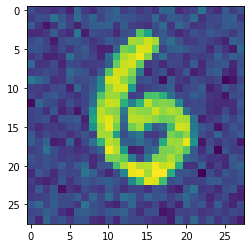

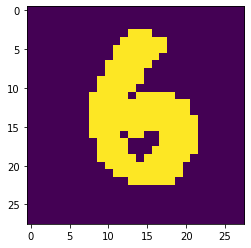

In [9]:
data = torch.from_numpy(scipy.io.loadmat('../data/mnist-six.mat')['data']).float()
segment_untouched = (data>150).long()
segment = (data>150).long()
segment2 = (data>5).long()


image = (data/255 + torch.randn_like(data)*.1).unsqueeze(1)
print(data.shape)
plt.imshow(image[152,0].cpu())
plt.show()
plt.imshow(segment2[152].cpu())

In [10]:
do_flip = torch.rand(800)>0.7#[::2]
# do_flip = torch.rand(800)>0.0#[::2]
idx_flip = torch.empty(0).long()
idx_clean = torch.empty(0).long()
for i in range(800):
    if(do_flip[i]):
        idx_flip = torch.cat((idx_flip,torch.tensor([i])))
        segment[i] = torch.roll(segment2[i].transpose(-2,-1),(int(torch.randn(1)*5),int(torch.randn(1)*5)),(0,1))
    else:
        idx_clean = torch.cat((idx_clean,torch.tensor([i])))

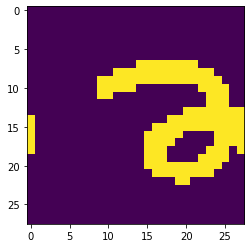

tensor([0, 1])


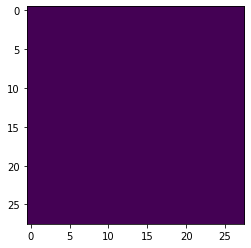

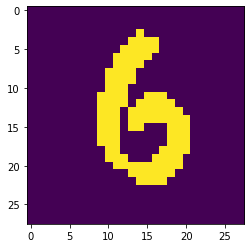

In [11]:
plt.imshow(segment[idx_flip[0]].cpu())
plt.show()
print(segment[0].unique())


x_or_intersect = torch.logical_xor(segment, segment_untouched)
or_intersect = torch.logical_or(segment, segment_untouched)
plt.imshow(x_or_intersect[152].cpu())
plt.show()
plt.imshow(or_intersect[152].cpu())
plt.show()

In [12]:
net = nn.Sequential(nn.Conv2d(1,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
                   nn.Conv2d(32,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
                   nn.Conv2d(32,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
                   nn.Conv2d(32,2,3,padding=1))


embedding = nn.Embedding(800, 1, sparse=True)
embedding

# torch.nn.init.constant_(embedding.weight, 1.)

run_loss_mattias = torch.zeros(500)
run_cc_mattias = torch.zeros(500)

net = net.cuda()
embedding = embedding.cuda()
image = image.cuda()
segment = segment.cuda()
run_loss_mattias = run_loss_mattias.cuda()
run_cc_mattias = run_cc_mattias.cuda()
do_flip = do_flip.cuda()

dices = torch.zeros(500)
dices = dices.cuda()


optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08)
optimizer_data = torch.optim.SparseAdam(embedding.parameters(), lr=0.1, betas=(0.9, 0.999), eps=1e-08)

for i in range(500):
    if i % 50 == 0:
        print(i)
    idx = torch.randperm(800)[:64]
    idx = idx.cuda()
    optimizer.zero_grad()
    optimizer_data.zero_grad()

    input = image[idx]
    output = net(input)

    loss_mattias = nn.CrossEntropyLoss(reduction='none')(output,segment[idx]).mean(-1).mean(-1)
    
    # print(loss)
    weight = torch.sigmoid(embedding(idx)).squeeze()
    weight = weight/weight.mean()
    
    (loss_mattias*weight).sum().backward()
    optimizer.step()
    optimizer_data.step()

    with torch.inference_mode():
        val_img, val_seg = image[800:], segment[800:]
        val_logits_for_score = net(val_img)
        # Calculate dice score

        run_cc_mattias[i] = np.corrcoef(torch.sigmoid(embedding.weight.detach()).cpu().squeeze().numpy(),do_flip.float().cpu().numpy())[0,1]
        run_loss_mattias[i] = (loss_mattias*(1-do_flip[idx].float())).mean().item()
        # Calculate dice score
        b_dice = dice2d(
            torch.nn.functional.one_hot(val_logits_for_score.argmax(1).long(), 2),
            torch.nn.functional.one_hot(val_seg, 2), # Calculate dice score with original segmentation (no disturbance)
            one_hot_torch_style=True
        )

        dices[i] = b_dice.mean()



0
50
100
150
200
250
300
350
400
450


In [8]:
# # Setup data parameter manager
# CLASSES = ['background', 'six']
# dpm = DataParameterManager(instance_keys=range(800), class_keys=CLASSES, config=config, device='cuda')

# net2 = nn.Sequential(nn.Conv2d(1,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
#                    nn.Conv2d(32,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
#                    nn.Conv2d(32,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
#                    nn.Conv2d(32,2,3,padding=1))

# optimizer2 = torch.optim.Adam(net2.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08)

# run_loss2 = torch.zeros(500)
# run_cc2 = torch.zeros(500)

# image = image.cuda()
# segment = segment.cuda()
# net2 = net2.cuda()
# run_loss2 = run_loss2.cuda()
# run_cc2 = run_cc2.cuda()
# do_flip = do_flip.cuda()

# for i in range(500):
#     if i % 50 == 0:
#         print(i)
#     idx = torch.randperm(800)[:64]
#     idx = idx.cuda()

#     optimizer2.zero_grad()

#     # Alt impl
#     _input = image[idx]
#     logits2 = net2(_input)
#     logits2 = logits2.permute(0,2,3,1)
#     _, loss = dpm.do_basic_train_step(
#         nn.BCEWithLogitsLoss(), 
#         logits2, 
#         torch.nn.functional.one_hot(segment[idx].long()), 
#         optimizer2, 
#         inst_keys=idx.tolist(),
#         scaler=None)

#     run_cc2[i] = torch.tensor(np.corrcoef(torch.sigmoid(dpm.get_parameter_tensor(inst_keys=range(800))).detach().cpu().numpy(), do_flip.float().cpu().numpy()))[0,1]
#     run_loss2[i] = (loss*(1-do_flip[idx].float())).mean().item()

In [43]:
import torch.cuda.amp as amp

net3 = nn.Sequential(nn.Conv2d(1,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
                   nn.Conv2d(32,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
                   nn.Conv2d(32,32,3,padding=1),nn.BatchNorm2d(32),nn.ReLU(),\
                   nn.Conv2d(32,2,3,padding=1))


embedding3 = nn.Embedding(800, 1, sparse=True)
torch.nn.init.constant_(embedding3.weight, 0.)
# torch.nn.init.normal_(embedding3.weight, mean=1., std=0.01)
# embedding3.weight = torch.rand_like(embedding3.weight)*1e-4 +1.

run_loss_mattias3 = torch.zeros(500)
run_cc_mattias3 = torch.zeros(500)

net3 = net3.cuda()
embedding3 = embedding3.cuda()
image = image.cuda()
segment = segment.cuda()
run_loss_mattias3 = run_loss_mattias3.cuda()
run_cc_mattias3 = run_cc_mattias3.cuda()
do_flip = do_flip.cuda()


optimizer3 = torch.optim.Adam(net3.parameters(), lr=0.0001, betas=(0.0, 0.0), eps=1e-08)
optimizer_data3 = torch.optim.SparseAdam(embedding3.parameters(), lr=0.1, betas=(0.0, 0.0), eps=1e-08)
scaler = amp.GradScaler()


for i in range(500):
    for g, h in zip(optimizer.param_groups, optimizer_data3.param_groups):
        mult = .5*(1-np.exp(-i/(10*800/64)))+.5
        print(mult)
        # mult=0
        g['betas'] = (mult*0.9, mult*0.999)
        h['betas'] = (1*0.9, 1*0.999)

    if i % 50 == 0:
        print(i)
    idx = torch.randperm(800)[:64]
    idx = idx.cuda()
    optimizer3.zero_grad()
    optimizer_data3.zero_grad()

    input = image[idx]
    output = net3(input)

    # Var 0
    # loss_mattias = nn.CrossEntropyLoss(reduction='none')(output,segment[idx]).mean((-1,-2))
    # weight = torch.sigmoid(embedding3(idx)).squeeze()
    # weight = weight/weight.mean()
    # dp_loss = loss_mattias*weight
    # dp_loss.sum().backward()

    # Var 1 working!
    # weight = embedding3(idx).squeeze()
    # dp_logits = output*weight.exp().view(-1,1,1,1)
    # loss_mattias = nn.CrossEntropyLoss(reduction='sum')(
    #     dp_logits,
    #     segment[idx]
    # )
    # dp_loss = loss_mattias
    # dp_loss.sum().backward()

    # Var 1.5
    # weight = embedding3(idx).squeeze()
    # dp_logits = output/torch.sigmoid(weight).view(-1,1,1,1)
    # loss_mattias = nn.CrossEntropyLoss(reduction='sum')(
    #     dp_logits,
    #     segment[idx]
    # )
    # dp_loss = loss_mattias
    # dp_loss.sum().backward()

    # Var 2, with autocast - setting embedding vector to 0 yields best performance
    with amp.autocast(enabled=True):
        loss = nn.CrossEntropyLoss(reduction='none')(output,segment[idx]).mean((-1,-2))
        weight = embedding3(idx)

        weight = torch.sigmoid(weight).squeeze()
        dp_loss = (loss*weight/weight.mean()).sum()

    scaler.scale(dp_loss).backward()
    scaler.step(optimizer3)        
    scaler.step(optimizer_data3)
    scaler.update()
    
    run_cc_mattias3[i] = np.corrcoef(torch.sigmoid(embedding3.weight.detach()).cpu().squeeze().numpy(),do_flip.float().cpu().numpy())[0,1]
    run_loss_mattias3[i] = (loss*(1-do_flip[idx].float())).mean().item()


0.5
0
0.5039840425814697
0.5079363399723574
0.5118571451210454
0.5157467089604012
0.5196052804238385
0.5234331064612476
0.5272304320548018
0.5309975002346352
0.5347345520943971
0.5384418268066822
0.5421195616383372
0.5457679919656468
0.5493873512893976
0.5529778712498215
0.5565397816414213
0.560073310427678
0.5635786837556404
0.5670561259703975
0.5705058596294383
0.5739281055168943
0.5773230826576706
0.5806910083314629
0.5840320980866641
0.5873465657541588
0.5906346234610091
0.5938964816440304
0.5971323490632602
0.6003424328153175
0.6035269383466582
0.6066860694667233
0.6098200283609829
0.6129290156038758
0.616013230171647
0.6190728694550812
0.6221081292721373
0.6251192038804794
0.6281062859899103
0.6310695667747044
0.6340092358858437
0.6369254814631545
0.6398184901473494
0.6426884470919714
0.6455355359752446
0.6483599390118295
0.6511618369644845
0.6539414091556348
0.6566988334788495
0.6594342864102265
0.662147943019687
0.6648399769821803
50
0.667510560588799
0.6701598647578055
0.67278

weights


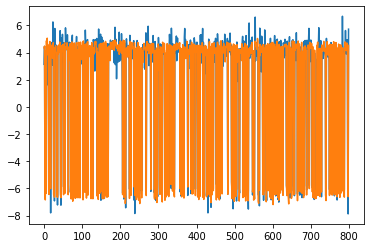

dices


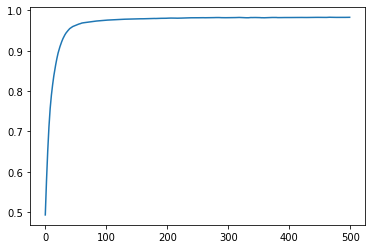

0.9824011921882629
loss


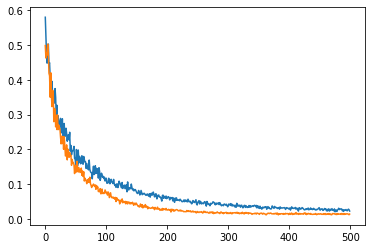

tensor(0.0220)
tensor(0.0133)
cc


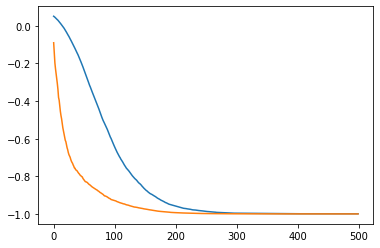

corr_coeff
-0.999114990234375
-0.9999520778656006
weight_std
4.721183776855469
4.838154315948486


In [44]:
print("weights")
plt.plot(embedding.weight.detach().cpu())
plt.plot(embedding3.weight.detach().cpu())
# plt.plot(dpm.get_parameter_tensor(inst_keys='all').detach().cpu().numpy())
# plt.plot(embedding4.weight.detach().mean(-1).cpu())

plt.show()

print("dices")
plt.plot(dices.cpu())
plt.plot([])
# plt.plot(dices4.cpu())
plt.show()
print(dices.cpu()[-1].item())
# print(dices4.cpu()[-1].item())

print("loss")
plt.plot(run_loss_mattias.cpu())
# plt.plot(run_loss2.cpu())
plt.plot(run_loss_mattias3.cpu())
# plt.plot(run_loss_mattias4.cpu())
plt.show()

print(run_loss_mattias.cpu()[-1])
# print(run_loss2.cpu()[-1])
print(run_loss_mattias3.cpu()[-1])
# print(run_loss_mattias4.cpu()[-1])

print("cc")
plt.plot(run_cc_mattias.cpu())
# plt.plot(run_cc2.cpu())
plt.plot(run_cc_mattias3.cpu())
# plt.plot(run_cc_mattias4.cpu())
plt.show()

print("corr_coeff")
print(run_cc_mattias.cpu()[-1].item())
# print(run_cc2.cpu()[-1].item())
print(run_cc_mattias3.cpu()[-1].item())
# print(run_cc_mattias4.cpu()[-1].item())

print("weight_std")
print(embedding.weight.detach().cpu().std().item())
# print(dpm.get_parameter_tensor(inst_keys='all').detach().cpu().std().item())
print(embedding3.weight.detach().cpu().std().item())
# print(embedding4.weight.detach().cpu().std().item())

# print("params")
# print(sum(p.numel() for p in net4.parameters()))
# print(sum(p.numel() for p in embedding4.parameters()))

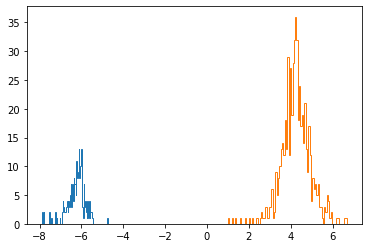

In [32]:
plt.hist(embedding(idx_flip.cuda()).cpu().detach().numpy(), bins=90, histtype='step');
plt.hist(embedding(idx_clean.cuda()).cpu().detach().numpy(), bins=90, histtype='step');

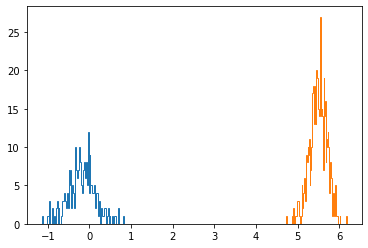

In [218]:
# plt.hist(embedding3(idx_flip.cuda()).cpu().detach().numpy(), bins=90, histtype='step');
# plt.hist(embedding3(idx_clean.cuda()).cpu().detach().numpy(), bins=90, histtype='step');

idx_map_flip = map_idxs(idx_flip.cuda(), GRID_SIZE_Y, GRID_SIZE_X)
idx_map_clean = map_idxs(idx_clean.cuda(), GRID_SIZE_Y, GRID_SIZE_X)

# mask_flip_idxs = torch.nn.functional.interpolate(x_or_intersect[idx_flip].unsqueeze(1).float(), size=(GRID_SIZE_Y, GRID_SIZE_Y)).squeeze(1).bool()
# masked_flipped_weights =  embedding4(idx_map_flip).view(-1,GRID_SIZE_Y, GRID_SIZE_X)[mask_flip_idxs]

# mask_flip_idxs = torch.nn.functional.interpolate(or_intersect[idx_flip].unsqueeze(1).float(), size=(GRID_SIZE_Y, GRID_SIZE_Y), mode='nearest').squeeze(1).float() # TODO best so far
# masked_flipped_weights =  embedding4(idx_map_flip).view(-1,GRID_SIZE_Y, GRID_SIZE_X) * mask_flip_idxs


mask_clean_idxs = or_intersect[idx_clean].float()
masked_clean_weights =  torch.nn.functional.interpolate(
    embedding4(idx_map_clean).view(-1,CLASS_CONTROL,GRID_SIZE_Y, GRID_SIZE_X), size=(mask_clean_idxs.shape[-2:]), mode='bilinear', align_corners=True)* mask_clean_idxs.unsqueeze(1)
masked_clean_weights[masked_clean_weights==0.] = float('nan')

mask_flip_idxs = or_intersect[idx_flip].float()
masked_flipped_weights =  torch.nn.functional.interpolate(
    embedding4(idx_map_flip).view(-1,CLASS_CONTROL,GRID_SIZE_Y, GRID_SIZE_X), size=(mask_flip_idxs.shape[-2:]), mode='bilinear', align_corners=True) * mask_flip_idxs.unsqueeze(1)
masked_flipped_weights[masked_flipped_weights==0.] = float('nan')
    
plt.hist(np.nanmean(masked_flipped_weights[:,CLASS_CONTROL-1].detach().cpu(), axis=(-2,-1)), bins=90, histtype='step');  
plt.hist(np.nanmean(masked_clean_weights[:,CLASS_CONTROL-1].detach().cpu(), axis=(-2,-1)), bins=90, histtype='step');      
# plt.hist((masked_flipped_weights).cpu().detach().numpy(), bins=90, histtype='step');

Sample


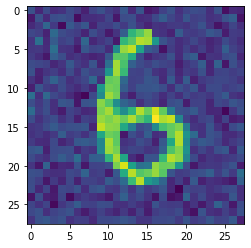

Ground-truth


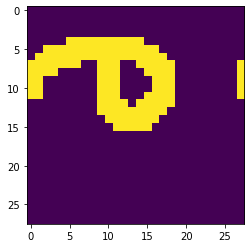

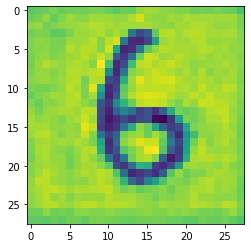

Show weightmaps
True map
-1.9563895463943481 7.983436107635498 2.829319477081299


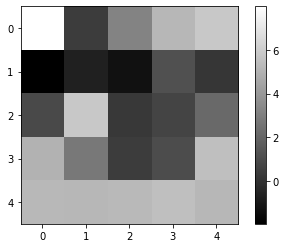

Predicted map


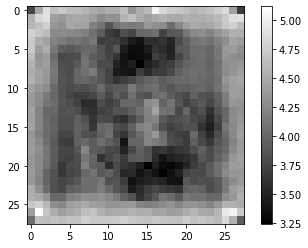

Orig logits


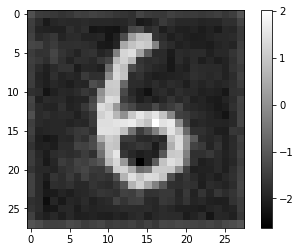

Weighted logits


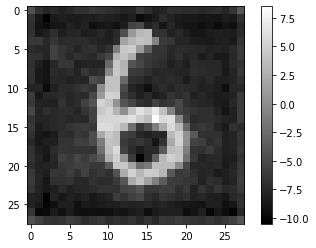

In [219]:
SHOW_IDX = 1
CLASS_NUM = 0

print("Sample")
plt.imshow(image[idx_flip[SHOW_IDX]].squeeze(0).cpu())
plt.show()

print("Ground-truth")
plt.imshow(segment[idx_flip[SHOW_IDX]].cpu())
plt.show()
plt.imshow(pred[0,CLASS_NUM].squeeze(0).cpu())
plt.show()

print('Show weightmaps')
print('True map')
show_weight = embedding4.weight[map_idxs(idx_flip[SHOW_IDX], GRID_SIZE_Y, GRID_SIZE_X)].view(-1,GRID_SIZE_Y,GRID_SIZE_X).unsqueeze(0)
show_weight = show_weight.view(-1, CLASS_CONTROL, GRID_SIZE_Y, GRID_SIZE_X)
disturbed_min, disturbed_max, disturbed_mean = show_weight.min().item(), show_weight.max().item(), show_weight.mean().item()
print(disturbed_min, disturbed_max, disturbed_mean)
plt.imshow(show_weight[0,CLASS_NUM].detach().cpu(), cmap='gray')
plt.colorbar()
plt.show()

print('Predicted map')
with amp.autocast(enabled=True):
    with torch.inference_mode():
        show_logits = net4(image[idx_flip[SHOW_IDX]].unsqueeze(0))
        uncertainty_map_inf = net4_uncertainty(torch.cat((image[idx_flip[SHOW_IDX]].unsqueeze(0), show_logits), dim=1))

plt.imshow((uncertainty_map_inf[0,CLASS_NUM].detach().view(28,28)).cpu().numpy(), cmap='gray')
plt.colorbar()
plt.show()

print('Orig logits')
plt.imshow((show_logits[:,1].detach().view(28,28)).cpu().numpy(), cmap='gray')
plt.colorbar()
plt.show()
print('Weighted logits')
plt.imshow(((uncertainty_map_inf[0,CLASS_NUM]*show_logits)[:,1].detach().view(28,28)).cpu().numpy(), cmap='gray')
plt.colorbar()
plt.show()

Sample


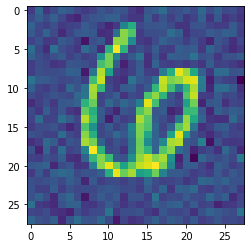

Ground-truth


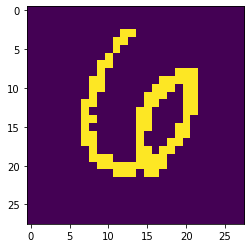

Show weightmaps
True map
2.3511219024658203 6.444005966186523 4.754271984100342


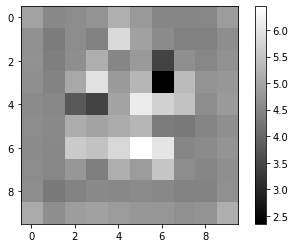

Predicted map


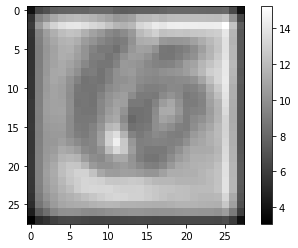

Orig logits


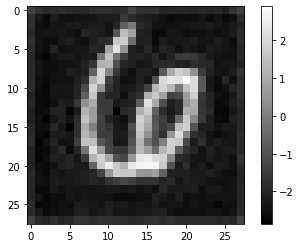

Weighted logits


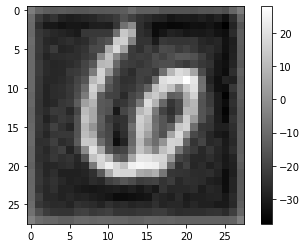

In [208]:
SHOW_IDX = 1
CLASS_NUM = 0

print("Sample")
plt.imshow(image[idx_clean[SHOW_IDX]].squeeze(0).cpu())
plt.show()

print("Ground-truth")
plt.imshow(segment[idx_clean[SHOW_IDX]].cpu())
plt.show()

print('Show weightmaps')
print('True map')
show_weight = embedding4.weight[map_idxs(idx_clean[SHOW_IDX], GRID_SIZE_Y, GRID_SIZE_X)].view(-1,GRID_SIZE_Y,GRID_SIZE_X).unsqueeze(0)
show_weight = show_weight.view(-1, CLASS_CONTROL, GRID_SIZE_Y, GRID_SIZE_X)
disturbed_min, disturbed_max, disturbed_mean = show_weight.min().item(), show_weight.max().item(), show_weight.mean().item()
print(disturbed_min, disturbed_max, disturbed_mean)
plt.imshow(show_weight[0,CLASS_NUM].detach().cpu(), cmap='gray')
plt.colorbar()
plt.show()

print('Predicted map')
with amp.autocast(enabled=True):
    with torch.inference_mode():
        show_logits = net4(image[idx_clean[SHOW_IDX]].unsqueeze(0))
        uncertainty_map_inf = net4_uncertainty(torch.cat((image[idx_clean[SHOW_IDX]].unsqueeze(0), show_logits), dim=1))

plt.imshow((uncertainty_map_inf[0,CLASS_NUM].detach().view(28,28)).cpu().numpy(), cmap='gray')
plt.colorbar()
plt.show()

print('Orig logits')
plt.imshow((show_logits[:,1].detach().view(28,28)).cpu().numpy(), cmap='gray')
plt.colorbar()
plt.show()
print('Weighted logits')
plt.imshow(((uncertainty_map_inf[0,CLASS_NUM]*show_logits)[:,1].detach().view(28,28)).cpu().numpy(), cmap='gray')
plt.colorbar()
plt.show()